In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime
import os
import glob
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Conv2D, AveragePooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.utils import multi_gpu_model


sns.set(style="darkgrid")
import dsmuc.io as io
import dsmuc.preprocessing as pp
import dsmuc.features as ff
import dsmuc.custom as cs

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = 6
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [3]:
def get_class_weights(y):
    y = np.asarray(y)
    from sklearn.utils import class_weight
    class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y.reshape(y.shape[0],))
                                               ,y.reshape(y.shape[0],))
    return  {cls: float(weight) for cls,weight in zip (np.unique(y.reshape(y.shape[0],)),class_weight)}

In [4]:
def auc_roc_plot(y_test, y_score, classes  = 'all'):
    from sklearn.metrics import roc_curve, auc
    if classes is None:
        classes = list(range(y_test.shape[1]))
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(classes, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    

In [5]:
def plot_cm(cm, classes, normalize = True):
    import seaborn as sns
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes[::-1]);
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()

## Inputs

In [6]:
raw_windows_path = "/home/ahmet/notebooks/data/G9_data/Raw/snippets/"
processed_file_path = "/home/ahmet/notebooks/data/G9_data/processed.csv"

In [7]:
columns = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']

In [8]:
win_paths = glob.glob(raw_windows_path+'*/*.csv')
print("Found {} windows".format(len(win_paths)))

Found 34519 windows


In [9]:
win_list = [pd.read_csv(win_paths[i], index_col='date', parse_dates=True) for i in range(len(win_paths))]

In [10]:
len(win_list)

34519

In [11]:
win_list[1].head()

,accX,accY,accZ,gyroX,gyroY,gyroZ,subject_id,label
date,,,,,,,,
2017-12-20 07:21:47.028,-9.797073,-2.552219,0.057461,0.044500,0.098412,0.390070,11,5
2017-12-20 07:21:47.051,-9.797073,-2.533065,0.071826,0.030651,0.086162,0.327219,11,5
2017-12-20 07:21:47.055,-9.619903,-2.542642,0.167594,0.001889,0.083498,0.255847,11,5
2017-12-20 07:21:47.081,-9.543288,-2.537854,0.177171,-0.018883,0.077107,0.180213,11,5
2017-12-20 07:21:47.095,-9.504981,-2.523489,0.215478,-0.023677,0.069650,0.108307,11,5


In [12]:
def get_raw(win_list):
    # Get data in raw format for models
    
    win_len = len(win_list)
    X , y , s=[], [], []
    for win in win_list:
        # Append data, label and subject id 
        X.append(win[columns].values)
        y.append(win['label'][0])
        s.append(win['subject_id'][0])
    return np.array(X), np.array(y), np.array(s)

def get_processed(processed_file_path):
    # Get Processed data to use in models
    
    df = pd.read_csv(processed_file_path)
    df.dropna(axis=0, how='any', inplace=True)
    X = df[df.columns[:-3]].values
    y = df['label']
    s = df['subject_id']
    return X, y, s 
    

In [13]:
X_raw, y_raw, s_raw = get_raw(win_list)

In [14]:
X_prep, y_prep, s_prep = get_processed(processed_file_path)

## CNN

In [15]:
def CNN():
    # 77% accuracy
    model = Sequential()
    model.add(Conv1D(8,
                    64,
                     input_shape=(timesteps,1),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=9))
    model.add(Conv1D(16,
                    16,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 7))
    model.add(Conv1D(64,
                    4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model

## RNN

In [16]:
def RNN():
    # 85% accuracy
    model = Sequential()
    model.add(Conv1D(8,
                    64,
                     input_shape=(timesteps,1),
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(16,
                    16,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(64,
                    4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(LSTM(64))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model

## MLP

In [17]:
def MLP():
    model = Sequential()
    model.add(Dense(512, input_shape =(timesteps,)))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256))
    model.add(Dense(256))
    model.add(Dense(32))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()
    return model

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
selected_model = 'RNN'

raw_models = ['CNN', 'MLP', 'RNN']
#LOO-Validation on each subject
if selected_model in raw_models:
    X = X_raw
    y = y_raw
    s = s_raw
else:
    X = X_prep
    y = y_prep
    s = s_prep
    
subject_list = np.unique(s_raw)
y_test_all = []
y_pred_all = []
y_score_all = []
np.random.seed(44)
iterations = shuffle(np.array(list(itertools.combinations(subject_list, 2))))

it_index = iterations[:20]
for subject in it_index: # two combination of tested subjects
    if os.path.exists('weights.hdf5'):
        os.remove('weights.hdf5')
    print("==================")
    print('Model tested on subjects with no : ', subject)
    mask_test = np.logical_or(s==subject[0], s== subject[1])
    mask_training = np.logical_and(s!=subject[0], s!= subject[1])
    X_test = X[mask_test]
    y_test = y[mask_test] -1
    X_training = X[mask_training] 
    y_training = y[mask_training] -1
    print("Test set and training set proportion : ",float(X_test.shape[0])/X_training.shape[0] )
    
    class_weight = get_class_weights(y_training)

    if not selected_model in raw_models : # Models will train on processed features
        if selected_model == "LogReg":
            model = LogisticRegression(class_weight = class_weight)
        elif selected_model == "SVM":
            model = svm.SVC( class_weight = class_weight, probability=True)
        elif selected_model == 'RForest':
            model = RandomForestClassifier(max_depth=10, n_estimators=20, class_weight=class_weight)
        
        model.fit(X_training, y_training)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
    else: # Models will train on raw data
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15,
                              verbose=0, mode='auto'),
            keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)]
        
        X_training = keras.preprocessing.sequence.pad_sequences(X_training, maxlen=128, dtype='float64',
            padding='pre', truncating='pre', value=0.)
        X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=128, dtype='float64',
            padding='pre', truncating='pre', value=0.)
        
        batch_size = 1500
        n_classes = 6
        
        if selected_model =='CNN':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape[0], -1,1)
            X_test = X_test.reshape(test_shape[0], -1,1)
            timesteps = len(X_training[0])
            model = CNN()
        elif selected_model =='RNN':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_training = X_training.reshape(train_shape[0], -1,1)
            X_test = X_test.reshape(test_shape[0], -1,1)
            timesteps = len(X_training[0])
            model = RNN()
        elif selected_model =='MLP':
            train_shape = X_training.shape
            test_shape = X_test.shape
            X_train = X_train.reshape(train_shape[0], -1)
            X_test = X_test.reshape(test_shape[0], -1)
            timesteps = len(X_training[0])
            model = MLP()
            
        # Compile model
#         multi_model = multi_gpu_model(model = model, gpus = 1)
        model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
        history =model.fit(X_training,
                  one_hot(y_training),
                  batch_size=batch_size,
                  validation_data=(X_test, one_hot(y_test)),
                  epochs=50,
                  callbacks=callbacks)
        
        model.load_weights('weights.hdf5')
        y_pred = model.predict(X_test).argmax(1)
        y_score = model.predict(X_test)
        print("")
        
    y_score_all.extend(y_score)
    y_test_all.extend(list(y_test))
    y_pred_all.extend(list(np.argmax(pd.rolling_mean(y_score, 50,min_periods=1), axis=1)))
    '''plt.figure()
    plt.plot(pd.rolling_mean( y_score, 50,min_periods=1), "-")
    plt.xlim([0, 1.5*len(y_score)])
    plt.legend(['walking',
            'walking upstairs',
            'walking downstairs',
            'sitting',
            'standing',
            'laying'], loc='upper_left')
    a = np.asarray(y_test).astype(np.int)
    y_ticks = np.asarray(['walking',
            'walking upstairs',
            'walking downstairs',
            'sitting',
            'standing',
            'laying'])[a]
    plt.plot(y_ticks)
    plt.xlim([0, 1.5*len(y_score)])'''
#     plt.savefig('Figures/'+str(subject[0])+'_'+str(subject[1])+'.png')

Model tested on subjects with no :  [  1 118]
Test set and training set proportion :  0.0416427773921965
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 705, 8)            520       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 352, 8)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 337, 16)           2064      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 168, 16)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 165, 64)           4160      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 82, 64)            0         
_____________________________________

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:104: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 705, 8)            520       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 352, 8)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 337, 16)           2064      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 168, 16)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 165, 64)           4160      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 82, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
__________

33152/33152 [==============================] - 4s 129us/step - loss: 1.0134 - acc: 0.6075 - val_loss: 0.9796 - val_acc: 0.5084

Epoch 00006: val_loss did not improve from 0.81858
Epoch 7/50
33152/33152 [==============================] - 4s 121us/step - loss: 0.9525 - acc: 0.6285 - val_loss: 0.9010 - val_acc: 0.6452

Epoch 00007: val_loss did not improve from 0.81858
Epoch 8/50
33152/33152 [==============================] - 4s 124us/step - loss: 0.9234 - acc: 0.6458 - val_loss: 0.6607 - val_acc: 0.7549

Epoch 00008: val_loss improved from 0.81858 to 0.66074, saving model to weights.hdf5
Epoch 9/50
33152/33152 [==============================] - 4s 129us/step - loss: 0.8960 - acc: 0.6495 - val_loss: 0.6230 - val_acc: 0.8083

Epoch 00009: val_loss improved from 0.66074 to 0.62295, saving model to weights.hdf5
Epoch 10/50
33152/33152 [==============================] - 4s 127us/step - loss: 0.8080 - acc: 0.6880 - val_loss: 0.8267 - val_acc: 0.7052

Epoch 00010: val_loss did not improve from 

Train on 32395 samples, validate on 2124 samples
Epoch 1/50
32395/32395 [==============================] - 6s 176us/step - loss: 1.3262 - acc: 0.4555 - val_loss: 1.5242 - val_acc: 0.3159

Epoch 00001: val_loss improved from inf to 1.52421, saving model to weights.hdf5
Epoch 2/50
32395/32395 [==============================] - 4s 129us/step - loss: 1.1361 - acc: 0.5527 - val_loss: 1.4466 - val_acc: 0.4440

Epoch 00002: val_loss improved from 1.52421 to 1.44656, saving model to weights.hdf5
Epoch 3/50
32395/32395 [==============================] - 4s 122us/step - loss: 1.0686 - acc: 0.5834 - val_loss: 1.6279 - val_acc: 0.3390

Epoch 00003: val_loss did not improve from 1.44656
Epoch 4/50
32395/32395 [==============================] - 4s 120us/step - loss: 1.0193 - acc: 0.6101 - val_loss: 1.3549 - val_acc: 0.4586

Epoch 00004: val_loss improved from 1.44656 to 1.35487, saving model to weights.hdf5
Epoch 5/50
32395/32395 [==============================] - 4s 126us/step - loss: 0.9894 - acc:

32395/32395 [==============================] - 4s 114us/step - loss: 0.4764 - acc: 0.8205 - val_loss: 1.2024 - val_acc: 0.5617

Epoch 00041: val_loss did not improve from 1.02469
Epoch 42/50
32395/32395 [==============================] - 4s 119us/step - loss: 0.4695 - acc: 0.8250 - val_loss: 1.0604 - val_acc: 0.5838

Epoch 00042: val_loss did not improve from 1.02469
Epoch 43/50
32395/32395 [==============================] - 4s 115us/step - loss: 0.4732 - acc: 0.8227 - val_loss: 1.1476 - val_acc: 0.5584

Epoch 00043: val_loss did not improve from 1.02469
Epoch 44/50
32395/32395 [==============================] - 4s 114us/step - loss: 0.4642 - acc: 0.8245 - val_loss: 1.2601 - val_acc: 0.5612

Epoch 00044: val_loss did not improve from 1.02469
Epoch 45/50
32395/32395 [==============================] - 4s 113us/step - loss: 0.4631 - acc: 0.8253 - val_loss: 1.1514 - val_acc: 0.5565

Epoch 00045: val_loss did not improve from 1.02469
Epoch 46/50
32395/32395 [==============================] 


Epoch 00026: val_loss improved from 0.72059 to 0.70202, saving model to weights.hdf5
Epoch 27/50
33942/33942 [==============================] - 4s 111us/step - loss: 0.5352 - acc: 0.7972 - val_loss: 0.8404 - val_acc: 0.6153

Epoch 00027: val_loss did not improve from 0.70202
Epoch 28/50
33942/33942 [==============================] - 4s 119us/step - loss: 0.5356 - acc: 0.8018 - val_loss: 0.7801 - val_acc: 0.6066

Epoch 00028: val_loss did not improve from 0.70202
Epoch 29/50
33942/33942 [==============================] - 4s 114us/step - loss: 0.5299 - acc: 0.8038 - val_loss: 0.6069 - val_acc: 0.7591

Epoch 00029: val_loss improved from 0.70202 to 0.60686, saving model to weights.hdf5
Epoch 30/50
33942/33942 [==============================] - 4s 124us/step - loss: 0.5212 - acc: 0.8023 - val_loss: 0.5598 - val_acc: 0.7470

Epoch 00030: val_loss improved from 0.60686 to 0.55976, saving model to weights.hdf5
Epoch 31/50
33942/33942 [==============================] - 4s 121us/step - loss: 0

33818/33818 [==============================] - 4s 115us/step - loss: 0.7857 - acc: 0.7060 - val_loss: 1.2161 - val_acc: 0.4807

Epoch 00010: val_loss improved from 1.53820 to 1.21610, saving model to weights.hdf5
Epoch 11/50
33818/33818 [==============================] - 4s 119us/step - loss: 0.7659 - acc: 0.7114 - val_loss: 2.4062 - val_acc: 0.2696

Epoch 00011: val_loss did not improve from 1.21610
Epoch 12/50
33818/33818 [==============================] - 4s 124us/step - loss: 0.7484 - acc: 0.7194 - val_loss: 1.9402 - val_acc: 0.2910

Epoch 00012: val_loss did not improve from 1.21610
Epoch 13/50
33818/33818 [==============================] - 4s 110us/step - loss: 0.7137 - acc: 0.7328 - val_loss: 2.1952 - val_acc: 0.2011

Epoch 00013: val_loss did not improve from 1.21610
Epoch 14/50
33818/33818 [==============================] - 4s 118us/step - loss: 0.7022 - acc: 0.7360 - val_loss: 1.7362 - val_acc: 0.3951

Epoch 00014: val_loss did not improve from 1.21610
Epoch 15/50
33818/33818

Train on 32434 samples, validate on 2085 samples
Epoch 1/50
32434/32434 [==============================] - 6s 193us/step - loss: 1.3550 - acc: 0.4442 - val_loss: 1.6090 - val_acc: 0.3108

Epoch 00001: val_loss improved from inf to 1.60897, saving model to weights.hdf5
Epoch 2/50
32434/32434 [==============================] - 4s 121us/step - loss: 1.1287 - acc: 0.5482 - val_loss: 1.3997 - val_acc: 0.3540

Epoch 00002: val_loss improved from 1.60897 to 1.39973, saving model to weights.hdf5
Epoch 3/50
32434/32434 [==============================] - 4s 110us/step - loss: 1.0645 - acc: 0.5842 - val_loss: 1.3105 - val_acc: 0.4854

Epoch 00003: val_loss improved from 1.39973 to 1.31047, saving model to weights.hdf5
Epoch 4/50
32434/32434 [==============================] - 4s 113us/step - loss: 0.9788 - acc: 0.6276 - val_loss: 1.1250 - val_acc: 0.5635

Epoch 00004: val_loss improved from 1.31047 to 1.12497, saving model to weights.hdf5
Epoch 5/50
32434/32434 [==============================] - 4

32467/32467 [==============================] - 4s 130us/step - loss: 0.6473 - acc: 0.7550 - val_loss: 0.9554 - val_acc: 0.5945

Epoch 00015: val_loss did not improve from 0.69078
Epoch 16/50
32467/32467 [==============================] - 4s 119us/step - loss: 0.6608 - acc: 0.7489 - val_loss: 1.1234 - val_acc: 0.5414

Epoch 00016: val_loss did not improve from 0.69078
Epoch 17/50
32467/32467 [==============================] - 4s 129us/step - loss: 0.6421 - acc: 0.7556 - val_loss: 0.8730 - val_acc: 0.6784

Epoch 00017: val_loss did not improve from 0.69078
Epoch 18/50
32467/32467 [==============================] - 4s 118us/step - loss: 0.6322 - acc: 0.7567 - val_loss: 1.0076 - val_acc: 0.5785

Epoch 00018: val_loss did not improve from 0.69078
Epoch 19/50
32467/32467 [==============================] - 4s 126us/step - loss: 0.6138 - acc: 0.7693 - val_loss: 1.1797 - val_acc: 0.5687

Epoch 00019: val_loss did not improve from 0.69078
Epoch 20/50
32467/32467 [==============================] 

32447/32447 [==============================] - 4s 111us/step - loss: 0.5398 - acc: 0.7986 - val_loss: 0.9286 - val_acc: 0.6757

Epoch 00028: val_loss did not improve from 0.91224
Epoch 29/50
32447/32447 [==============================] - 4s 118us/step - loss: 0.5396 - acc: 0.8010 - val_loss: 0.9649 - val_acc: 0.6892

Epoch 00029: val_loss did not improve from 0.91224
Epoch 30/50
32447/32447 [==============================] - 4s 121us/step - loss: 0.5153 - acc: 0.8110 - val_loss: 1.1196 - val_acc: 0.6332

Epoch 00030: val_loss did not improve from 0.91224
Epoch 31/50
32447/32447 [==============================] - 4s 112us/step - loss: 0.5156 - acc: 0.8089 - val_loss: 1.0022 - val_acc: 0.6443

Epoch 00031: val_loss did not improve from 0.91224

Model tested on subjects with no :  [ 21 102]
Test set and training set proportion :  0.03982287556104467
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37

33197/33197 [==============================] - 4s 115us/step - loss: 0.5549 - acc: 0.7904 - val_loss: 0.4042 - val_acc: 0.8707

Epoch 00029: val_loss improved from 0.47178 to 0.40418, saving model to weights.hdf5
Epoch 30/50
33197/33197 [==============================] - 4s 108us/step - loss: 0.5569 - acc: 0.7900 - val_loss: 0.5597 - val_acc: 0.8033

Epoch 00030: val_loss did not improve from 0.40418
Epoch 31/50
33197/33197 [==============================] - 4s 112us/step - loss: 0.5402 - acc: 0.7960 - val_loss: 0.4794 - val_acc: 0.8442

Epoch 00031: val_loss did not improve from 0.40418
Epoch 32/50
33197/33197 [==============================] - 4s 108us/step - loss: 0.5482 - acc: 0.7928 - val_loss: 0.5103 - val_acc: 0.8071

Epoch 00032: val_loss did not improve from 0.40418
Epoch 33/50
33197/33197 [==============================] - 4s 110us/step - loss: 0.5313 - acc: 0.8018 - val_loss: 0.5242 - val_acc: 0.8313

Epoch 00033: val_loss did not improve from 0.40418
Epoch 34/50
33197/33197


Epoch 00018: val_loss did not improve from 0.94522
Epoch 19/50
33151/33151 [==============================] - 4s 106us/step - loss: 0.6302 - acc: 0.7656 - val_loss: 0.9618 - val_acc: 0.7171

Epoch 00019: val_loss did not improve from 0.94522
Epoch 20/50
33151/33151 [==============================] - 4s 112us/step - loss: 0.6343 - acc: 0.7613 - val_loss: 0.9905 - val_acc: 0.7354

Epoch 00020: val_loss did not improve from 0.94522
Epoch 21/50
33151/33151 [==============================] - 4s 106us/step - loss: 0.6154 - acc: 0.7717 - val_loss: 0.9243 - val_acc: 0.7405

Epoch 00021: val_loss improved from 0.94522 to 0.92433, saving model to weights.hdf5
Epoch 22/50
33151/33151 [==============================] - 4s 110us/step - loss: 0.5900 - acc: 0.7798 - val_loss: 1.2928 - val_acc: 0.6250

Epoch 00022: val_loss did not improve from 0.92433
Epoch 23/50
33151/33151 [==============================] - 4s 111us/step - loss: 0.6001 - acc: 0.7800 - val_loss: 1.0125 - val_acc: 0.6681

Epoch 0002

34018/34018 [==============================] - 4s 104us/step - loss: 0.6706 - acc: 0.7493 - val_loss: 0.9388 - val_acc: 0.6427

Epoch 00016: val_loss improved from 0.96789 to 0.93879, saving model to weights.hdf5
Epoch 17/50
34018/34018 [==============================] - 4s 110us/step - loss: 0.6441 - acc: 0.7547 - val_loss: 1.0376 - val_acc: 0.5808

Epoch 00017: val_loss did not improve from 0.93879
Epoch 18/50
34018/34018 [==============================] - 4s 105us/step - loss: 0.6435 - acc: 0.7579 - val_loss: 0.9639 - val_acc: 0.6148

Epoch 00018: val_loss did not improve from 0.93879
Epoch 19/50
34018/34018 [==============================] - 4s 105us/step - loss: 0.6268 - acc: 0.7628 - val_loss: 1.0207 - val_acc: 0.5210

Epoch 00019: val_loss did not improve from 0.93879
Epoch 20/50
34018/34018 [==============================] - 4s 114us/step - loss: 0.6113 - acc: 0.7721 - val_loss: 0.8173 - val_acc: 0.7146

Epoch 00020: val_loss improved from 0.93879 to 0.81729, saving model to we

Train on 33175 samples, validate on 1344 samples
Epoch 1/50
33175/33175 [==============================] - 6s 180us/step - loss: 1.3522 - acc: 0.4580 - val_loss: 1.0705 - val_acc: 0.6443

Epoch 00001: val_loss improved from inf to 1.07051, saving model to weights.hdf5
Epoch 2/50
33175/33175 [==============================] - 4s 111us/step - loss: 1.1585 - acc: 0.5533 - val_loss: 0.9751 - val_acc: 0.6287

Epoch 00002: val_loss improved from 1.07051 to 0.97509, saving model to weights.hdf5
Epoch 3/50
33175/33175 [==============================] - 4s 106us/step - loss: 1.0921 - acc: 0.5715 - val_loss: 0.9551 - val_acc: 0.5350

Epoch 00003: val_loss improved from 0.97509 to 0.95512, saving model to weights.hdf5
Epoch 4/50
33175/33175 [==============================] - 4s 120us/step - loss: 1.0493 - acc: 0.5905 - val_loss: 0.8598 - val_acc: 0.7135

Epoch 00004: val_loss improved from 0.95512 to 0.85978, saving model to weights.hdf5
Epoch 5/50
33175/33175 [==============================] - 4

33175/33175 [==============================] - 4s 110us/step - loss: 0.5050 - acc: 0.8118 - val_loss: 0.8395 - val_acc: 0.7760

Epoch 00042: val_loss did not improve from 0.31984
Epoch 43/50
33175/33175 [==============================] - 4s 108us/step - loss: 0.4906 - acc: 0.8154 - val_loss: 0.7835 - val_acc: 0.6860

Epoch 00043: val_loss did not improve from 0.31984
Epoch 44/50
33175/33175 [==============================] - 4s 116us/step - loss: 0.4896 - acc: 0.8195 - val_loss: 0.9952 - val_acc: 0.7560

Epoch 00044: val_loss did not improve from 0.31984
Epoch 45/50
33175/33175 [==============================] - 4s 108us/step - loss: 0.4965 - acc: 0.8157 - val_loss: 0.5599 - val_acc: 0.7753

Epoch 00045: val_loss did not improve from 0.31984
Epoch 46/50
33175/33175 [==============================] - 4s 109us/step - loss: 0.4718 - acc: 0.8249 - val_loss: 0.8753 - val_acc: 0.7783

Epoch 00046: val_loss did not improve from 0.31984
Epoch 47/50
33175/33175 [==============================] 

32428/32428 [==============================] - 4s 110us/step - loss: 0.6071 - acc: 0.7728 - val_loss: 0.6866 - val_acc: 0.6958

Epoch 00027: val_loss did not improve from 0.56314
Epoch 28/50
32428/32428 [==============================] - 4s 108us/step - loss: 0.5332 - acc: 0.7994 - val_loss: 0.6461 - val_acc: 0.7542

Epoch 00028: val_loss did not improve from 0.56314
Epoch 29/50
32428/32428 [==============================] - 3s 108us/step - loss: 0.5539 - acc: 0.7935 - val_loss: 0.5436 - val_acc: 0.8417

Epoch 00029: val_loss improved from 0.56314 to 0.54363, saving model to weights.hdf5
Epoch 30/50
32428/32428 [==============================] - 4s 112us/step - loss: 0.5449 - acc: 0.7949 - val_loss: 0.5912 - val_acc: 0.7513

Epoch 00030: val_loss did not improve from 0.54363
Epoch 31/50
32428/32428 [==============================] - 3s 107us/step - loss: 0.5343 - acc: 0.7977 - val_loss: 0.6574 - val_acc: 0.7226

Epoch 00031: val_loss did not improve from 0.54363
Epoch 32/50
32428/32428

32482/32482 [==============================] - 4s 111us/step - loss: 0.7458 - acc: 0.7251 - val_loss: 1.3902 - val_acc: 0.4629

Epoch 00012: val_loss did not improve from 1.24609
Epoch 13/50
32482/32482 [==============================] - 3s 107us/step - loss: 0.7175 - acc: 0.7333 - val_loss: 1.3455 - val_acc: 0.4772

Epoch 00013: val_loss did not improve from 1.24609
Epoch 14/50
32482/32482 [==============================] - 4s 114us/step - loss: 0.6803 - acc: 0.7505 - val_loss: 1.4533 - val_acc: 0.5218

Epoch 00014: val_loss did not improve from 1.24609
Epoch 15/50
32482/32482 [==============================] - 4s 109us/step - loss: 0.6939 - acc: 0.7400 - val_loss: 1.4179 - val_acc: 0.4438

Epoch 00015: val_loss did not improve from 1.24609
Epoch 16/50
32482/32482 [==============================] - 4s 110us/step - loss: 0.6561 - acc: 0.7609 - val_loss: 1.4080 - val_acc: 0.5474

Epoch 00016: val_loss did not improve from 1.24609
Epoch 17/50
32482/32482 [==============================] 


Epoch 00024: val_loss did not improve from 0.37112
Epoch 25/50
33976/33976 [==============================] - 3s 101us/step - loss: 0.5754 - acc: 0.7816 - val_loss: 0.3700 - val_acc: 0.8711

Epoch 00025: val_loss improved from 0.37112 to 0.37002, saving model to weights.hdf5
Epoch 26/50
33976/33976 [==============================] - 4s 105us/step - loss: 0.5804 - acc: 0.7808 - val_loss: 0.3359 - val_acc: 0.8803

Epoch 00026: val_loss improved from 0.37002 to 0.33586, saving model to weights.hdf5
Epoch 27/50
33976/33976 [==============================] - 4s 104us/step - loss: 0.5770 - acc: 0.7824 - val_loss: 0.3443 - val_acc: 0.8785

Epoch 00027: val_loss did not improve from 0.33586
Epoch 28/50
33976/33976 [==============================] - 4s 110us/step - loss: 0.5532 - acc: 0.7909 - val_loss: 0.3625 - val_acc: 0.8656

Epoch 00028: val_loss did not improve from 0.33586
Epoch 29/50
33976/33976 [==============================] - 4s 105us/step - loss: 0.5580 - acc: 0.7913 - val_loss: 0.

33779/33779 [==============================] - 4s 118us/step - loss: 0.8606 - acc: 0.6733 - val_loss: 1.8288 - val_acc: 0.2351

Epoch 00008: val_loss did not improve from 1.42614
Epoch 9/50
33779/33779 [==============================] - 4s 108us/step - loss: 0.8197 - acc: 0.6928 - val_loss: 1.3317 - val_acc: 0.4743

Epoch 00009: val_loss improved from 1.42614 to 1.33174, saving model to weights.hdf5
Epoch 10/50
33779/33779 [==============================] - 4s 110us/step - loss: 0.7969 - acc: 0.7022 - val_loss: 1.2293 - val_acc: 0.4838

Epoch 00010: val_loss improved from 1.33174 to 1.22934, saving model to weights.hdf5
Epoch 11/50
33779/33779 [==============================] - 4s 113us/step - loss: 0.7818 - acc: 0.7055 - val_loss: 1.2217 - val_acc: 0.5243

Epoch 00011: val_loss improved from 1.22934 to 1.22168, saving model to weights.hdf5
Epoch 12/50
33779/33779 [==============================] - 4s 110us/step - loss: 0.7383 - acc: 0.7220 - val_loss: 1.3168 - val_acc: 0.5108

Epoch 0

33779/33779 [==============================] - 4s 110us/step - loss: 0.4412 - acc: 0.8388 - val_loss: 0.7475 - val_acc: 0.5892

Epoch 00049: val_loss did not improve from 0.71361
Epoch 50/50
33779/33779 [==============================] - 4s 109us/step - loss: 0.4370 - acc: 0.8420 - val_loss: 0.7893 - val_acc: 0.5878

Epoch 00050: val_loss did not improve from 0.71361

Model tested on subjects with no :  [  4 115]
Test set and training set proportion :  0.05167108430064284
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 705, 8)            520       
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 352, 8)            0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 337, 16)           2064      
_____________________________________________________________


Epoch 00031: val_loss improved from 0.65912 to 0.64083, saving model to weights.hdf5
Epoch 32/50
32823/32823 [==============================] - 4s 110us/step - loss: 0.5302 - acc: 0.8018 - val_loss: 0.6730 - val_acc: 0.7034

Epoch 00032: val_loss did not improve from 0.64083
Epoch 33/50
32823/32823 [==============================] - 4s 113us/step - loss: 0.5308 - acc: 0.8012 - val_loss: 0.7299 - val_acc: 0.7022

Epoch 00033: val_loss did not improve from 0.64083
Epoch 34/50
32823/32823 [==============================] - 3s 106us/step - loss: 0.5372 - acc: 0.8018 - val_loss: 0.6493 - val_acc: 0.7093

Epoch 00034: val_loss did not improve from 0.64083
Epoch 35/50
32823/32823 [==============================] - 4s 122us/step - loss: 0.5202 - acc: 0.8065 - val_loss: 0.6786 - val_acc: 0.7075

Epoch 00035: val_loss did not improve from 0.64083
Epoch 36/50
32823/32823 [==============================] - 4s 111us/step - loss: 0.5070 - acc: 0.8132 - val_loss: 0.6746 - val_acc: 0.6869

Epoch 0003

32471/32471 [==============================] - 4s 129us/step - loss: 0.7909 - acc: 0.6940 - val_loss: 0.5637 - val_acc: 0.8555

Epoch 00015: val_loss improved from 0.59795 to 0.56375, saving model to weights.hdf5
Epoch 16/50
32471/32471 [==============================] - 4s 118us/step - loss: 0.7490 - acc: 0.7116 - val_loss: 0.6240 - val_acc: 0.8354

Epoch 00016: val_loss did not improve from 0.56375
Epoch 17/50
32471/32471 [==============================] - 4s 116us/step - loss: 0.7434 - acc: 0.7117 - val_loss: 0.5714 - val_acc: 0.8594

Epoch 00017: val_loss did not improve from 0.56375
Epoch 18/50
32471/32471 [==============================] - 4s 127us/step - loss: 0.7429 - acc: 0.7172 - val_loss: 0.5032 - val_acc: 0.8535

Epoch 00018: val_loss improved from 0.56375 to 0.50317, saving model to weights.hdf5
Epoch 19/50
32471/32471 [==============================] - 3s 107us/step - loss: 0.7156 - acc: 0.7252 - val_loss: 0.4988 - val_acc: 0.8545

Epoch 00019: val_loss improved from 0.50

Confusion matrix, without normalization


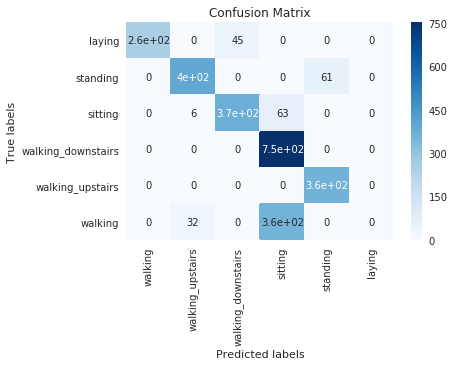

Normalized confusion matrix


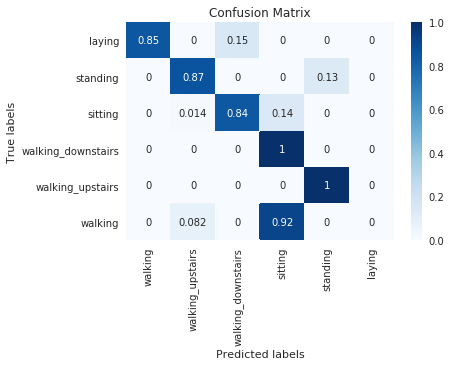

In [29]:
label_dict = {1:'walking',
             2:'walking_upstairs',
             3:'walking_downstairs',
             4:'sitting',
             5:'standing',
             6:'laying'}
class_names = list(label_dict.values())


cnf_matrix = confusion_matrix(y_test_all, y_pred_all)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=False)

# Plot normalized confusion matrix
plt.figure()
plot_cm(cnf_matrix, class_names, normalize=True)
# plt.savefig(save_with_name+'.png')
plt.show()

In [30]:
true_pos = np.diag(cnf_matrix).sum()
accuracy = true_pos/float(cnf_matrix.sum())
print('Overall accuracy of the Model', accuracy)

Overall accuracy of the Model 0.7906203840472673


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test_all, y_pred_all,target_names=class_names))

                    precision    recall  f1-score   support

           walking       1.00      0.85      0.92       300
  walking_upstairs       0.91      0.87      0.89       457
walking_downstairs       0.89      0.84      0.87       443
           sitting       0.64      1.00      0.78       752
          standing       0.86      1.00      0.92       364
            laying       0.00      0.00      0.00       392

       avg / total       0.70      0.79      0.73      2708



/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


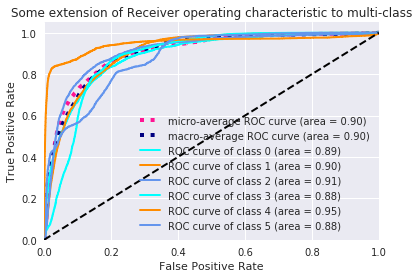

In [64]:
auc_roc_plot(one_hot(np.array(y_test_all)), np.array(y_score_all), None)

In [25]:
os.remove('weights.hdf5')

FileNotFoundError: [Errno 2] No such file or directory: 'weights.hdf5'

In [ ]:
# Input Data 

training_data_count = len(X_train_used)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test_used)  # 2947 testing series
 
timesteps = len(X_train_used[0]) # 128 timesteps per series
# input_dim = len(X_train_used[0][0]) # 6 input parameters per timestep

# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300
# Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X test shape, y test shape, every X's mean, every X's standard deviation)")
print(X_test_used.shape, y_test.shape, np.mean(X_test_used), np.std(X_test_used))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")